In [1]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import math as m
from sklearn import svm

import itertools

import seaborn as sns
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import gc

from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer


from xgboost import XGBRegressor, XGBClassifier
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression

In [2]:
# bokeh plotting
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
from bokeh.layouts import row, column
from bokeh.models import PrintfTickFormatter
from bokeh.models import CustomJS, DateRangeSlider
from bokeh.models import Legend, ColumnDataSource, Label, LabelSet, Range1d
from bokeh.palettes import magma, viridis
output_notebook(hide_banner=True)


import matplotlib.pyplot as plt

In [3]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Data

In [4]:
PATH = "../data/Очищенные обработанные данные.csv"

In [5]:
df = pd.read_csv(PATH, delimiter = ',').drop(columns= ['nplv'])

In [6]:
TARGETS = ['сыпуч известь РП']

In [7]:
cols = set(df.columns) - set(TARGETS)
nan_cols=[col for col in cols if df[col].isnull().values.any()]

In [8]:
def knn_impute(df, col):
    imputer = KNNImputer(n_neighbors=2)
    imp_col = imputer.fit_transform(df[col].to_numpy().reshape(-1, 1))
    imp_col = [item[0] for item in imp_col.tolist()]
    df[col] = imp_col

In [9]:
#Стратегия knn 
for col in nan_cols:
    knn_impute(df, col)

In [10]:
with open('cols_for_modelling.txt') as f:
    FEATURES = f.read().splitlines()

with open('cols_for_engineering.txt') as f:
    pairs = f.read().splitlines()
    EXTRA_FEAT = [eval(pair) for pair in pairs]

class Error(Exception):
    pass

class InputError(Error):
    """Exception raised for errors in the input."""
    def __init__(self, expression, message):
        self.expression = expression
        self.message = message


def safe_division(x, y):
    if (x != x) | (y != y) | (y == 0):
        return np.nan
    return x / y


def feature_engineering(df):
    df_new = df.copy()
    # ratio
    for pair in EXTRA_FEAT:
        new_col = pair[0]+'_'+pair[1]+'_ratio'
        df_new[new_col] = df.apply(lambda x: safe_division(x[pair[0]],x[pair[1]]), axis=1)
    # substraction
    t_features = ['t вып-обр', 't обработка', 't под током', 't продувка']
    t_combinations = list(itertools.combinations(t_features, 2))
    for pair in t_combinations:
        new_col = pair[0]+'_'+pair[1]+'_sub'
        df_new[new_col] = df.apply(lambda x: abs(x[pair[0]]-x[pair[1]]), axis=1)
    return df_new

In [11]:
df = feature_engineering(df)

In [12]:
df.columns

Index(['t вып-обр', 't обработка', 't под током', 't продувка', 'ПСН гр.',
       'чист расход C', 'чист расход Cr', 'чист расход Mn', 'чист расход Si',
       'чист расход V', 'температура первая', 'температура последняя',
       'Ar (интенс.)', 'эл. энергия (интенс.)', 'произв жидкая сталь',
       'произв количество обработок', 'расход газ Ar', 'сыпуч известь РП',
       'сыпуч кокс пыль УСТК', 'сыпуч  кокс. мелочь КМ1', 'сыпуч  шпат плав.',
       'ферспл CaC2', 'ферспл  FeV-80', 'ферспл  Mn5Si65Al0.5',
       'ферспл SiMn18', 'ферспл  фх850А', 'эл. энергия',
       'химсталь первый Al_1', 'химсталь первый C_1', 'химсталь первый Cr_1',
       'химсталь первый Cu_1', 'химсталь первый Mn_1', 'химсталь первый Mo_1',
       'химсталь первый N_1', 'химсталь первый Ni_1', 'химсталь первый P_1',
       'химсталь первый S_1', 'химсталь первый Si_1', 'химсталь первый Ti_1',
       'химсталь первый V_1', 'химсталь последний Al', 'химсталь последний C',
       'химсталь последний Ca', 'химста

# Train

In [13]:
data = df.dropna()
data = data.reset_index(drop=True)

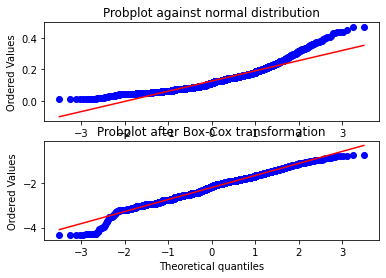

In [39]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
x = data[TARGETS[0]].values
prob = ss.probplot(x, dist=ss.norm, plot=ax1)
ax1.set_xlabel('')
ax1.set_title('Probplot against normal distribution')

ax2 = fig.add_subplot(212)
xt = np.log(x)
prob = ss.probplot(xt, dist=ss.norm, plot=ax2)
ax2.set_title('Probplot after Box-Cox transformation')
plt.show()

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(columns = TARGETS).values,
    data[TARGETS].values,
    test_size=0.2,
    shuffle = False)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [16]:
y_train_bc = np.log(y_train[:, 0])
y_test_bc = np.log(y_test[:, 0])
y_val_bc = np.log(y_val[:, 0])

In [17]:
def compute_metrics(y_true, y_pred):
    return np.array([r2_score(y_true, y_pred), mean_absolute_error(y_true, y_pred), \
                    mean_squared_error(y_true, y_pred), mean_absolute_percentage_error(y_true, y_pred)])

    '''
    print(f'R2 : {r2_score(y_true, y_pred)}')
    print(f'MAE : {mean_absolute_error(y_true, y_pred)}')
    print(f'MSE : {mean_squared_error(y_true, y_pred)}')
    print(f'MAPe : {mean_absolute_percentage_error(y_true, y_pred)}')
    '''

In [27]:
import pickle

### XGBoost

In [18]:
gr_reg = XGBRegressor(n_estimators=500, learning_rate=0.01)
gr_reg.fit(X_train, y_train, 
             early_stopping_rounds=5, 
             eval_set=[(X_val, y_val)],
             verbose=False)
y_pred = gr_reg.predict(X_test)

In [19]:
compute_metrics(y_test, y_pred)

array([4.52106543e-01, 4.40809944e-02, 3.47040456e-03, 7.25537639e+01])

In [72]:
filename = 'xgboost.sav'
pickle.dump(gr_reg, open(filename, 'wb'))

In [58]:
tmp_data = pd.DataFrame(data = X_test, columns = np.setdiff1d(data.columns, TARGETS))
tmp_data['error'] = y_test[:, 0] - y_pred

### Linear Regression

In [21]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

In [39]:
y_pred_lin = lin_reg.predict(X_test)

In [40]:
lin_reg.coef_.max()

389.4452649987896

In [41]:
compute_metrics(y_test, y_pred_lin)

array([2.95950806e-01, 4.51172071e-02, 4.45950851e-03, 5.18443924e+01])

In [28]:
filename = 'lin_reg_l2.sav'
pickle.dump(lin_reg, open(filename, 'wb'))

## L1 norm

In [49]:
from scipy.optimize import minimize

In [91]:
def fit(X, params):
    return X.dot(params)


def cost_function(params, X, y):
    return np.sum(np.abs(y - fit(X, params)))

In [79]:
def fit1(X, params):
    return X.dot(params[0]) + params[1]


def cost_function1(params, X, y):
    return np.sum(np.abs(y - fit1(X, params)))

In [92]:
x0 = (-1 + 2*np.random.rand(X_train.shape[1])) / X_train.shape[1]
x1 = np.random.rand()

In [ ]:
output = minimize(cost_function, x0, args=(X_train, y_train))

In [75]:
y_pred = fit(X_test, output.x)

ValueError: shapes (597,86) and (172,) not aligned: 86 (dim 1) != 172 (dim 0)

In [54]:
compute_metrics(y_test, y_pred)

array([4.64372623e-01, 4.43317984e-02, 3.39271015e-03, 7.15490853e+01])

## KNN

In [29]:
from sklearn import neighbors

In [30]:
n_neighbors = 5

In [31]:
knn = neighbors.KNeighborsRegressor(n_neighbors, weights='distance')
knn.fit(X_train, y_train)

KNeighborsRegressor(weights='distance')

In [32]:
y_pred = knn.predict(X_test)[:, 0]

In [33]:
compute_metrics(y_test[:, 0], y_pred)

array([-3.46333281e-01,  6.72977569e-02,  8.52779149e-03,  5.31545325e+01])

In [34]:
filename = 'knn_5.sav'
pickle.dump(knn, open(filename, 'wb'))

In [ ]:
lin_reg

## Random Forest

In [42]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

In [43]:
regr = RandomForestRegressor(max_depth=8, random_state=1)
regr.fit(X_train, y_train[:, 0])

RandomForestRegressor(max_depth=8, random_state=1)

In [44]:
y_pred = regr.predict(X_test)

In [45]:
compute_metrics(y_test[:, 0], y_pred)

array([4.11322319e-01, 4.48896587e-02, 3.72873536e-03, 4.21505071e+01])

In [48]:
filename = 'random_forest.sav'
pickle.dump(regr, open(filename, 'wb'))

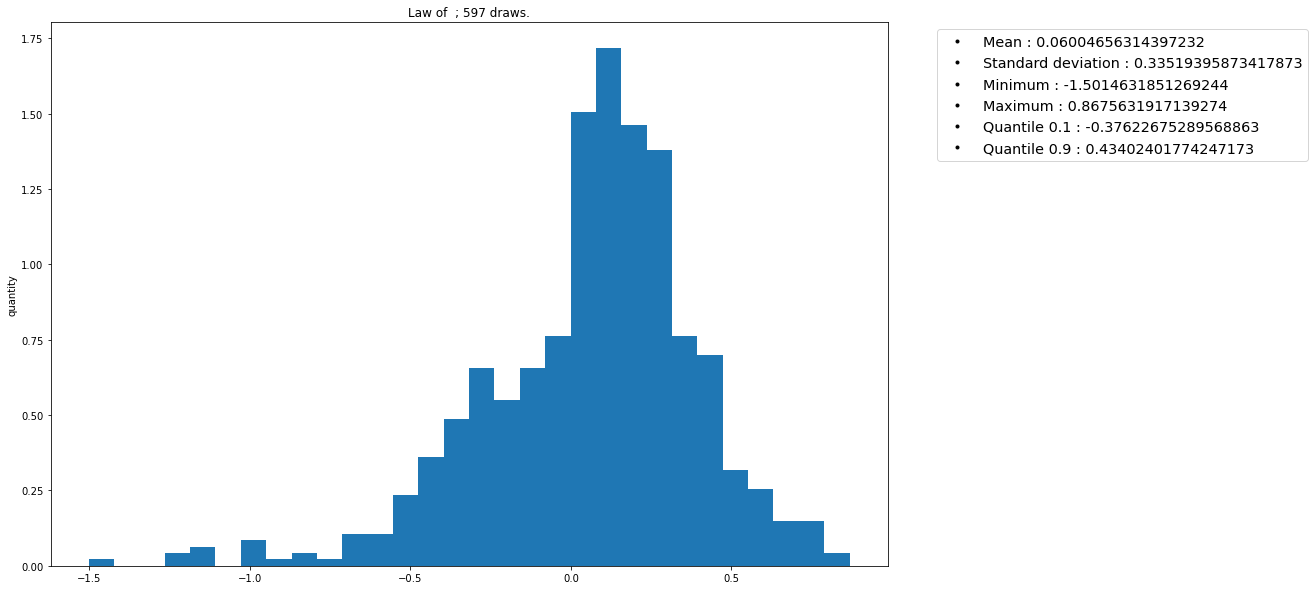

In [240]:
plot_hist(y_test[:, 0] - y_pred, 30, name = '')

## Gaussian process

In [241]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic

In [259]:
kernel = RationalQuadratic(alpha = 2)

In [260]:
reg = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=2)
reg.fit(X_train, y_train[:, 0])

GaussianProcessRegressor(kernel=RationalQuadratic(alpha=2, length_scale=1),
                         n_restarts_optimizer=2)

In [261]:
y_pred = reg.predict(X_test)

In [262]:
compute_metrics(y_test[:, 0], y_pred)

array([-0.28424774,  0.37838817,  0.22087343, 26.16654785])